# Decomposing Time Series

### Loading Libraries

In [1]:
%cd ../..

/Users/joaquinromero/Desktop


In [70]:
# Numerical Computing
import numpy as np

# Data Manipulation
import pandas as pd

# Data Visualization
import seaborn as sns
import plotly.io as pio
import plotly.express as px
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Warnings
import warnings

# IO & Requests
import requests
from io import StringIO

# OS
import os
import sys
import pickleshare
import missingno as msno
from itertools import cycle

# PyArrow
import pyarrow as pa

# Path & Notebook Optimizer
from pathlib import Path
import missingno as msno
from tqdm.auto import tqdm

# StatsModels
import statsmodels.api as sm
from statsmodels.tsa.seasonal import MSTL , DecomposeResult

# Scikit-Learn
from sklearn.metrics import mean_absolute_error

# IPython
from IPython.display import display, HTML

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
tqdm.pandas()

np.random.seed()

pio.templates.default = "plotly_white"

sys.path.append('/Users/joaquinromero/Desktop/MTSF')

In [5]:
warnings.filterwarnings("ignore", category=UserWarning)

warnings.filterwarnings("ignore", category=FutureWarning)

warnings.filterwarnings("ignore", message="'force_all_finite' was renamed to 'ensure_all_finite'")

In [6]:
os.makedirs("imgs/chapter_03", exist_ok=True)

preprocessed = Path.home() / "Desktop" / "data" / "london_smart_meters" / "preprocessed"

In [7]:
assert preprocessed.is_dir(), "You have to run 02 - Preprocessing London Smart Meter Dataset.ipynb in Chapter02 before running this notebook"

In [8]:
from itertools import cycle

def format_plot(fig, legends=None, xlabel="Time", ylabel="Value", font_size=15, title_font_size=20):
    if legends:
        names = cycle(legends)
        fig.for_each_trace(lambda t: t.update(name=next(names)))
        
    fig.update_layout(
        autosize=False,
        width=900,
        height=500,
        title=dict(
            text=fig.layout.title.text if fig.layout.title.text else "",
            x=0.5,
            xanchor="center",
            yanchor="top",
            font=dict(size=title_font_size)
        ),
        legend_title=None,
        legend=dict(
            font=dict(size=font_size),
            orientation="h",
            yanchor="bottom",
            y=0.98,
            xanchor="right",
            x=1,
        ),
        yaxis=dict(
            title=dict(
                text=ylabel,
                font=dict(size=font_size)
            ),
            tickfont=dict(size=font_size)
        ),
        xaxis=dict(
            title=dict(
                text=xlabel,
                font=dict(size=font_size)
            ),
            tickfont=dict(size=font_size)
        )
    )
    
    return fig

### Generate Charts for Trend and Seasonality

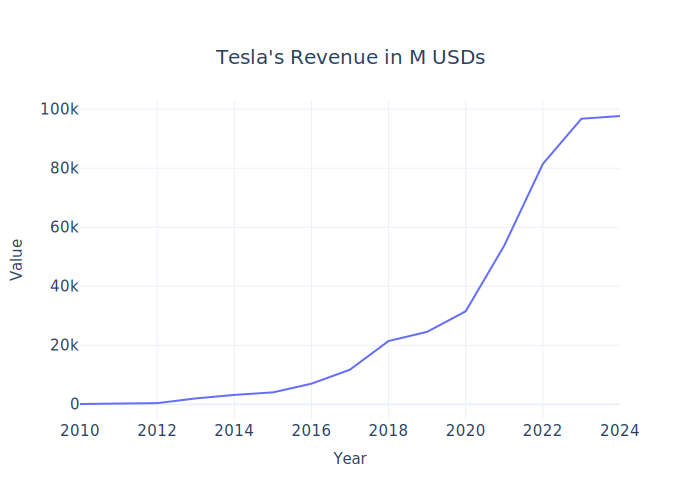

In [9]:
# Creating a session and disabling SSL verification (be cautious with this approach due to security concerns)
session = requests.Session()
#session.verify = False

url = "https://en.wikipedia.org/wiki/Tesla,_Inc."
r = session.get(url)  # Use the session object here for the request
website = r.text

# Wrap the HTML content in a StringIO object
tesla_revenue = pd.read_html(StringIO(website), encoding="UTF-8")[7][['Year', "Revenue (US$ m)"]]

tesla_revenue = tesla_revenue[tesla_revenue.Year>=2010]
fig = px.line(tesla_revenue, x="Year", y="Revenue (US$ m)", title="Tesla's Revenue in M USDs")
fig = format_plot(fig, xlabel="Year")
fig.write_image("imgs/chapter_03/tesla_revenue.png")
fig.show(renderer="svg")

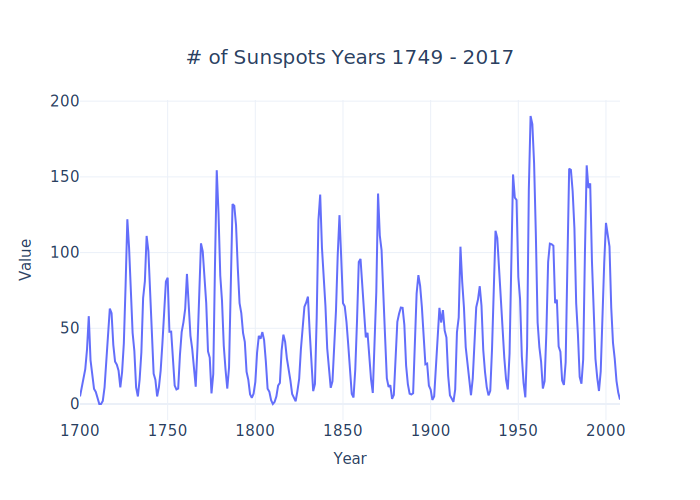

In [14]:
df = sm.datasets.sunspots.load_pandas().data
fig=px.line(df, x="YEAR", y="SUNACTIVITY", title="# of Sunspots Years 1749 - 2017")
fig = format_plot(fig, xlabel="Year")
fig.write_image("imgs/chapter_03/sunspots.png")
fig.show(renderer="svg")

In [15]:
df = pd.DataFrame({"x": np.arange(13)})

for i in range(1,4):
    df[f'Fourier Cosine Term {i}'] = np.cos((2 * np.pi * df.x * i) / 12)
    df[f'Fourier Sine Term {i}'] = np.sin((2 * np.pi * df.x * i) / 12)

df = pd.melt(df, id_vars="x",var_name="Fourier Terms")

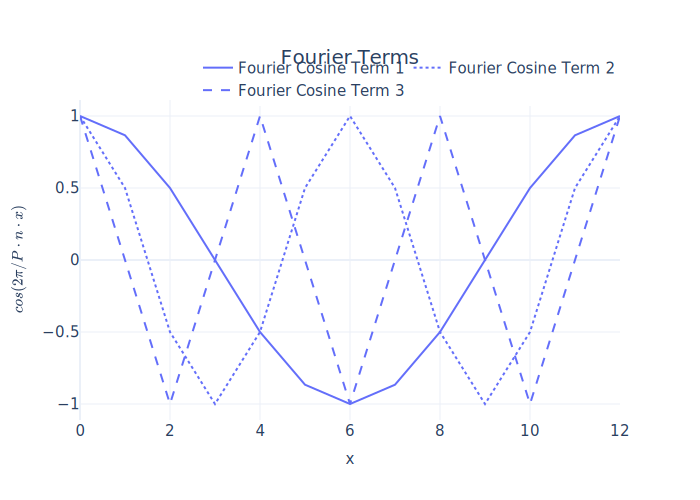

In [18]:
fig = px.line(df[df['Fourier Terms'].str.contains("Cosine")], x="x", y="value", line_dash="Fourier Terms", title="Fourier Terms")
fig = format_plot(fig, xlabel="x", ylabel="$cos(2\pi/P \cdot n \cdot x)$")
fig.write_image("imgs/chapter_03/fourier_terms.png")
fig.show(renderer="svg")

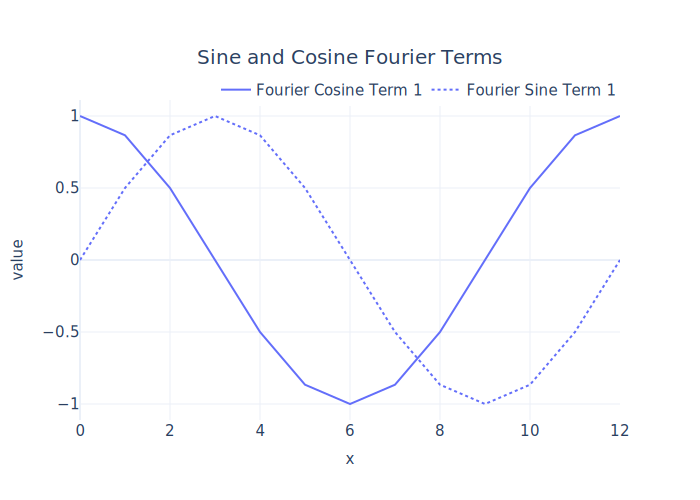

In [19]:
fig = px.line(df[df['Fourier Terms'].str.contains("Term 1")], x="x", y="value", line_dash="Fourier Terms", title="Sine and Cosine Fourier Terms")
fig = format_plot(fig, xlabel="x", ylabel="value")
fig.write_image("imgs/chapter_03/sine_cos_terms.png")
fig.show(renderer="svg")

### Reading Blocks 0-7

In [20]:
from src.utils.data_utils import compact_to_expanded

In [21]:
try:
    block_df = pd.read_parquet(preprocessed/"london_smart_meters_merged_block_0-7.parquet")
    display(block_df.head())
except FileNotFoundError:
    display(HTML("""
    <div class="alert alert-block alert-warning">
    <b>Warning!</b> File not found. Please make sure you have run 02 - Preprocessing London Smart Meter Dataset.ipynb in Chapter02
    </div>
    """))

LCLid start_timestamp frequency  \
0  MAC000002      2012-10-13     30min   
1  MAC000246      2012-01-01     30min   
2  MAC000450      2012-03-23     30min   
3  MAC001074      2012-05-09     30min   
4  MAC003223      2012-09-18     30min   

                                  energy_consumption  series_length stdorToU  \
0  [0.263, 0.2689999999999999, 0.275, 0.256, 0.21...          24144      Std   
1  [0.509, 0.317, 0.253, 0.249, 0.93, 0.607, 0.10...          37872      Std   
2  [1.337, 1.426, 0.996, 0.971, 0.994, 0.952, 0.8...          33936      Std   
3  [0.18, 0.086, 0.106, 0.173, 0.146, 0.223, 0.21...          31680      ToU   
4  [0.076, 0.079, 0.123, 0.109, 0.051, 0.069, 0.0...          25344      Std   

     Acorn Acorn_grouped     file  \
0  ACORN-A      Affluent  block_0   
1  ACORN-A      Affluent  block_0   
2  ACORN-A      Affluent  block_0   
3   ACORN-        ACORN-  block_0   
4  ACORN-A      Affluent  block_0   

                                            holidays  ...  \
0  [NO_HOLIDAY, NO_HOLIDAY, NO_HOLIDAY, NO_HOLIDA...  ...   
1  [NO_HOLIDAY, NO_HOLIDAY, NO_HOLIDAY, NO_HOLIDA...  ...   
2  [NO_HOLIDAY, NO_HOLIDAY, NO_HOLIDAY, NO_HOLIDA...  ...   
3  [NO_HOLIDAY, NO_HOLIDAY, NO_HOLIDAY, NO_HOLIDA...  ...   
4  [NO_HOLIDAY, NO_HOLIDAY, NO_HOLIDAY, NO_HOLIDA...  ...   

                                         windBearing  \
0  [186, 186, 188, 188, 190, 190, 203, 203, 206, ...   
1  [229, 229, 238, 238, 229, 229, 231, 231, 227, ...   
2  [78, 78, 73, 73, 81, 81, 80, 80, 75, 75, 71, 7...   
3  [215, 215, 207, 207, 215, 215, 216, 216, 126, ...   
4  [236, 236, 240, 240, 242, 242, 244, 244, 248, ...   

                                         temperature  \
0  [8.78, 8.78, 8.27, 8.27, 7.87, 7.87, 7.89, 7.8...   
1  [12.12, 12.12, 12.59, 12.59, 12.45, 12.45, 12....   
2  [8.76, 8.76, 8.54, 8.54, 8.09, 8.09, 7.34, 7.3...   
3  [11.46, 11.46, 11.38, 11.38, 11.38, 11.38, 10....   
4  [14.06, 14.06, 13.12, 13.12, 12.53, 12.53, 12....   

                                            dewPoint  \
0  [6.28, 6.28, 6.21, 6.21, 6.22, 6.22, 6.76, 6.7...   
1  [10.97, 10.97, 11.02, 11.02, 11.04, 11.04, 10....   
2  [7.25, 7.25, 7.12, 7.12, 7.17, 7.17, 6.68, 6.6...   
3  [10.23, 10.23, 10.17, 10.17, 10.24, 10.24, 10....   
4  [10.82, 10.82, 10.29, 10.29, 9.86, 9.86, 9.83,...   

                                            pressure  \
0  [1007.7, 1007.7, 1007.36, 1007.36, 1006.73, 10...   
1  [1008.1, 1008.1, 1007.88, 1007.88, 1007.95, 10...   
2  [1027.41, 1027.41, 1026.91, 1026.91, 1026.54, ...   
3  [1007.39, 1007.39, 1007.21, 1007.21, 1007.06, ...   
4  [1011.09, 1011.09, 1010.82, 1010.82, 1010.65, ...   

                                 apparentTemperature  \
0  [7.55, 7.55, 7.34, 7.34, 6.75, 6.75, 6.89, 6.8...   
1  [12.12, 12.12, 12.59, 12.59, 12.45, 12.45, 12....   
2  [7.59, 7.59, 7.43, 7.43, 7.24, 7.24, 7.34, 7.3...   
3  [11.46, 11.46, 11.38, 11.38, 11.38, 11.38, 10....   
4  [14.06, 14.06, 13.12, 13.12, 12.53, 12.53, 12....   

                                           windSpeed  \
0  [2.28, 2.28, 1.81, 1.81, 1.95, 1.95, 1.83, 1.8...   
1  [5.9, 5.9, 6.06, 6.06, 5.31, 5.31, 4.68, 4.68,...   
2  [2.18, 2.18, 2.07, 2.07, 1.72, 1.72, 1.34, 1.3...   
3  [2.35, 2.35, 2.15, 2.15, 1.84, 1.84, 1.22, 1.2...   
4  [3.86, 3.86, 3.81, 3.81, 4.27, 4.27, 4.12, 4.1...   

                                          precipType  \
0  [rain, rain, rain, rain, rain, rain, rain, rai...   
1  [rain, rain, rain, rain, rain, rain, rain, rai...   
2  [rain, rain, rain, rain, rain, rain, rain, rai...   
3  [rain, rain, rain, rain, rain, rain, rain, rai...   
4  [rain, rain, rain, rain, rain, rain, rain, rai...   

                                                icon  \
0  [clear-night, clear-night, clear-night, clear-...   
1  [partly-cloudy-night, partly-cloudy-night, clo...   
2  [fog, fog, fog, fog, fog, fog, fog, fog, fog, ...   
3  [partly-cloudy-night, partly-cloudy-night, par...   
4  [clear-night, clear-night, clear-night, c

In [22]:
#Converting to expanded form
exp_block_df = compact_to_expanded(block_df[block_df.file=="block_7"], timeseries_col = 'energy_consumption',
static_cols = ["frequency", "series_length", "stdorToU", "Acorn", "Acorn_grouped", "file"],
time_varying_cols = ['holidays', 'visibility', 'windBearing', 'temperature', 'dewPoint',
       'pressure', 'apparentTemperature', 'windSpeed', 'precipType', 'icon',
       'humidity', 'summary'],
ts_identifier = "LCLid")

exp_block_df.head()

  0%|          | 0/50 [00:00<?, ?it/s]

timestamp      LCLid  energy_consumption frequency  series_length  \
0 2012-01-01 00:00:00  MAC000050               0.175     30min          37872   
1 2012-01-01 00:30:00  MAC000050               0.212     30min          37872   
2 2012-01-01 01:00:00  MAC000050               0.313     30min          37872   
3 2012-01-01 01:30:00  MAC000050               0.302     30min          37872   
4 2012-01-01 02:00:00  MAC000050               0.257     30min          37872   

  stdorToU    Acorn Acorn_grouped     file    holidays  ...  windBearing  \
0      Std  ACORN-D      Affluent  block_7  NO_HOLIDAY  ...          229   
1      Std  ACORN-D      Affluent  block_7  NO_HOLIDAY  ...          229   
2      Std  ACORN-D      Affluent  block_7  NO_HOLIDAY  ...          238   
3      Std  ACORN-D      Affluent  block_7  NO_HOLIDAY  ...          238   
4      Std  ACORN-D      Affluent  block_7  NO_HOLIDAY  ...          229   

   temperature  dewPoint  pressure  apparentTemperature  windSpeed  \
0        12.12     10.97   1008.10                12.12       5.90   
1        12.12     10.97   1008.10                12.12       5.90   
2        12.59     11.02   1007.88                12.59       6.06   
3        12.59     11.02   1007.88                12.59       6.06   
4        12.45     11.04   1007.95                12.45       5.31   

   precipType                 icon humidity        summary  
0        rain  partly-cloudy-night     0.93  Mostly Cloudy  
1        rain  partly-cloudy-night     0.93  Mostly Cloudy  
2        rain               cloudy     0.90       Overcast  
3        rain               cloudy     0.90       Overcast  
4        rain  partly-cloudy-night     0.91  Mostly Cloudy  

[5 rows x 21 columns]

In [23]:
# Taking a single time series from the block
ts_df = exp_block_df[exp_block_df.LCLid=="MAC000193"].set_index("timestamp")

#### Filling in Missing Values

In [24]:
from src.imputation.interpolation import SeasonalInterpolation

ts = SeasonalInterpolation(seasonal_period=48*7).fit_transform(ts_df.energy_consumption.values.reshape(-1,1)).squeeze()

### Seasonal Decomposition

In [25]:
from statsmodels.tsa.seasonal import seasonal_decompose
from src.decomposition.seasonal import STL, FourierDecomposition, MultiSeasonalDecomposition

In [29]:
# def decomposition_plot(
#         ts_index, observed=None, seasonal=None, trend=None, resid=None
#     ):
#         """Plots the decomposition output
#         """
#         series = []
#         if observed is not None:
#             series += ["Original"]
#         if trend is not None:
#             series += ["Trend"]
#         if seasonal is not None:
#             series += ["Seasonal"]
#         if resid is not None:
#             series += ["Residual"]
#         if len(series) == 0:
#             raise ValueError(
#                 "All component flags were off. Need atleast one of the flags turned on to plot."
#             )
#         fig = make_subplots(
#             rows=len(series), cols=1, shared_xaxes=True, subplot_titles=series
#         )
#         x = ts_index
#         row = 1
#         if observed is not None:
#             fig.append_trace(
#                 go.Scatter(x=x, y=observed, name="Original"), row=row, col=1
#             )
#             row += 1
#         if trend is not None:
#             fig.append_trace(
#                 go.Scatter(x=x, y=trend, name="Trend"), row=row, col=1
#             )
#             row += 1
#         if seasonal is not None:
#             fig.append_trace(
#                 go.Scatter(x=x, y=seasonal, name="Seasonal"),
#                 row=row,
#                 col=1,
#             )
#             row += 1
#         if resid is not None:
#             fig.append_trace(
#                 go.Scatter(x=x, y=resid, name="Residual"), row=row, col=1
#             )
#             row += 1

#         fig.update_layout(
#             title_text="Seasonal Decomposition",
#             autosize=False,
#             width=1200,
#             height=700,
#             title={"x": 0.5, "xanchor": "center", "yanchor": "top"},
#             titlefont={"size": 20},
#             legend_title=None,
#             showlegend=False,
#             legend=dict(
#                 font=dict(size=15),
#                 orientation="h",
#                 yanchor="bottom",
#                 y=0.98,
#                 xanchor="right",
#                 x=1,
#             ),
#             yaxis=dict(
#                 # title_text=ylabel,
#                 titlefont=dict(size=15),
#                 tickfont=dict(size=15),
#             ),
#             xaxis=dict(
#                 # title_text=xlabel,
#                 titlefont=dict(size=15),
#                 tickfont=dict(size=15),
#             )
#         )
#         return fig

In [30]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

def decomposition_plot(ts_index, observed=None, seasonal=None, trend=None, resid=None):
    """
    Plots the decomposition output of a time series with optional components.
    Parameters:
        ts_index (array-like): Time index
        observed (array-like): Original time series
        seasonal (array-like): Seasonal component
        trend (array-like): Trend component
        resid (array-like): Residual component
    Returns:
        fig (plotly.graph_objs.Figure): Plotly figure
    """
    series = []
    if observed is not None:
        series.append("Original")
    if trend is not None:
        series.append("Trend")
    if seasonal is not None:
        series.append("Seasonal")
    if resid is not None:
        series.append("Residual")
    if not series:
        raise ValueError("At least one component must be provided to plot.")

    fig = make_subplots(
        rows=len(series),
        cols=1,
        shared_xaxes=True,
        subplot_titles=series
    )

    x = ts_index
    row = 1
    if observed is not None:
        fig.add_trace(go.Scatter(x=x, y=observed, name="Original"), row=row, col=1)
        row += 1
    if trend is not None:
        fig.add_trace(go.Scatter(x=x, y=trend, name="Trend"), row=row, col=1)
        row += 1
    if seasonal is not None:
        fig.add_trace(go.Scatter(x=x, y=seasonal, name="Seasonal"), row=row, col=1)
        row += 1
    if resid is not None:
        fig.add_trace(go.Scatter(x=x, y=resid, name="Residual"), row=row, col=1)

    fig.update_layout(
        title=dict(
            text="Seasonal Decomposition",
            x=0.5,
            xanchor="center",
            yanchor="top",
            font=dict(size=20)
        ),
        autosize=False,
        width=1200,
        height=700,
        showlegend=False,
    )

    fig.update_yaxes(tickfont=dict(size=15))
    fig.update_xaxes(tickfont=dict(size=15))

    return fig

### Moving Averages

In [31]:
#Does not support misssing values, so using imputed ts instead
res = seasonal_decompose(ts, period=7*48, model="additive", extrapolate_trend="freq", filt=np.repeat(1/(30*48), 30*48))

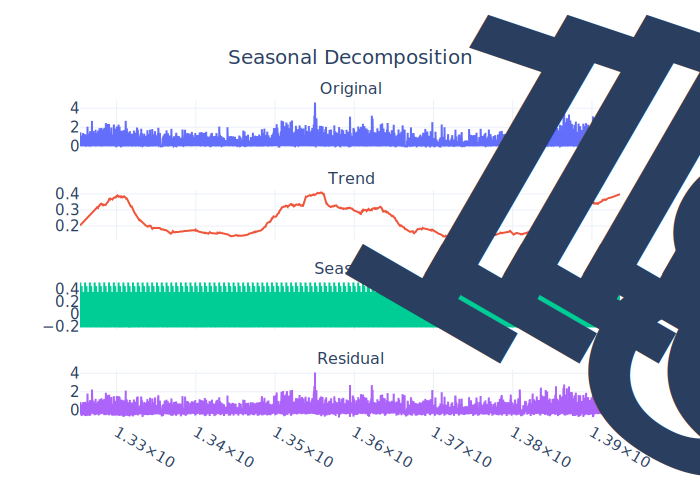

In [32]:
fig = decomposition_plot(ts_df.index, res.observed, res.seasonal, res.trend, res.resid)
fig.write_image("imgs/chapter_03/moving_avg_decomposition.png")
fig.show(renderer="svg")

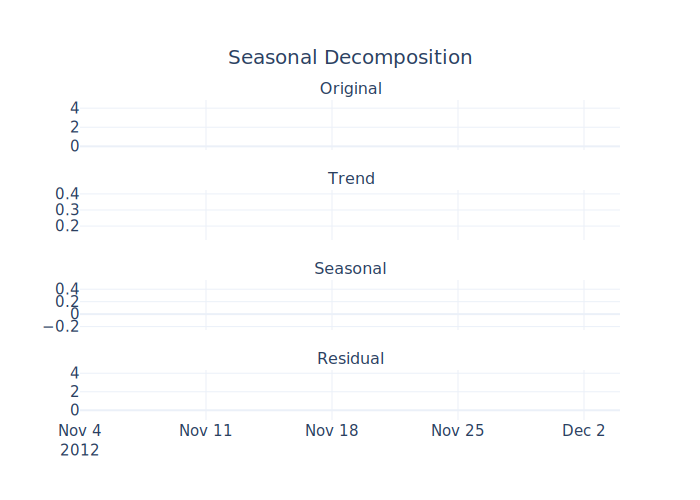

In [33]:
#Let's zoom in on a few days to better see the seasonality extracted
fig.update_xaxes(type="date", range=["2012-11-4", "2012-12-4"])
fig.write_image("imgs/chapter_03/moving_avg_decomposition_zoomed.png")
fig.show(renderer="svg")

### Seasonality and Trend Decomposition using Loess (STL)

In [34]:
#Supports missing values and expects a series or dataframe with datetime index
stl = STL(seasonality_period=7*48, model = "additive")
res_new = stl.fit(ts_df.energy_consumption)

In [36]:
# fig = res_new.plot(interactive=True)
# fig.update_layout(
#             legend=dict(
#                 font=dict(size=15),
#                 orientation="h",
#                 yanchor="bottom",
#                 y=0.98,
#                 xanchor="right",
#                 x=1,
#             ),
#             yaxis=dict(
#                 # title_text=ylabel,
#                 titlefont=dict(size=15),
#                 tickfont=dict(size=15),
#             ),
#             xaxis=dict(
#                 # title_text=xlabel,
#                 titlefont=dict(size=15),
#                 tickfont=dict(size=15),
#             )
#         )
# fig.write_image("imgs/chapter_03/stl_decomposition.png")
# fig.show(renderer="svg")

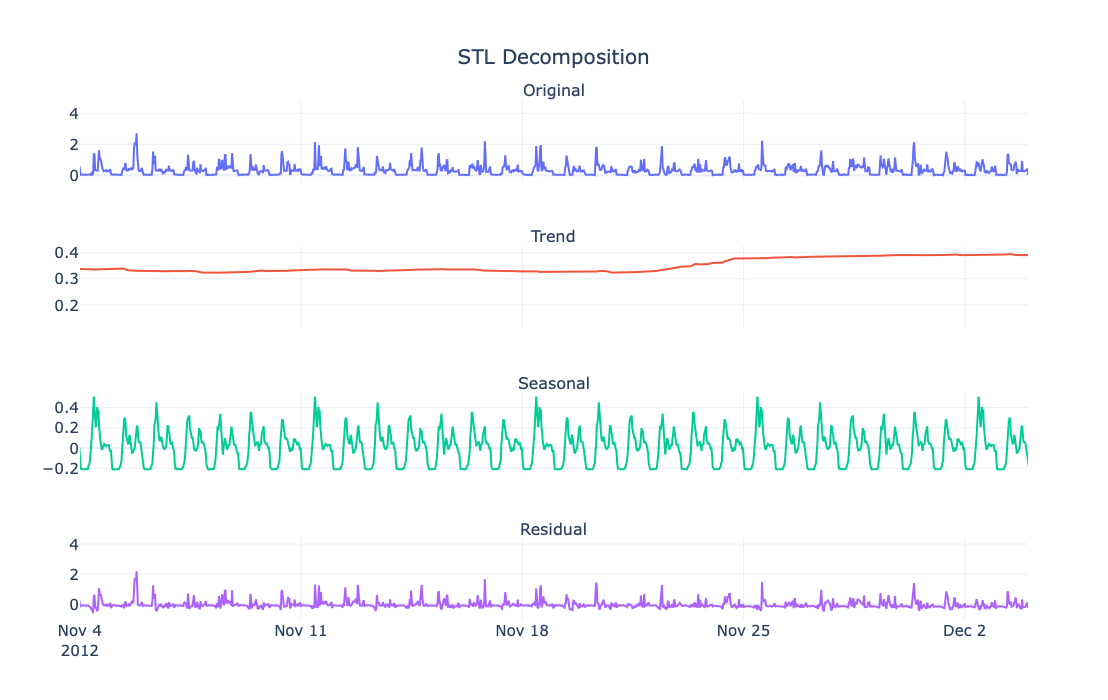

In [37]:
import os

fig.update_layout(
    title=dict(
        text="STL Decomposition",
        x=0.5,
        xanchor="center",
        font=dict(size=20)
    ),
    legend=dict(
        font=dict(size=15),
        orientation="h",
        yanchor="bottom",
        y=0.98,
        xanchor="right",
        x=1,
    ),
    yaxis=dict(
        title=dict(font=dict(size=15)),
        tickfont=dict(size=15),
    ),
    xaxis=dict(
        title=dict(font=dict(size=15)),
        tickfont=dict(size=15),
    )
)

fig.write_image("imgs/chapter_03/stl_decomposition.png")
fig.show()

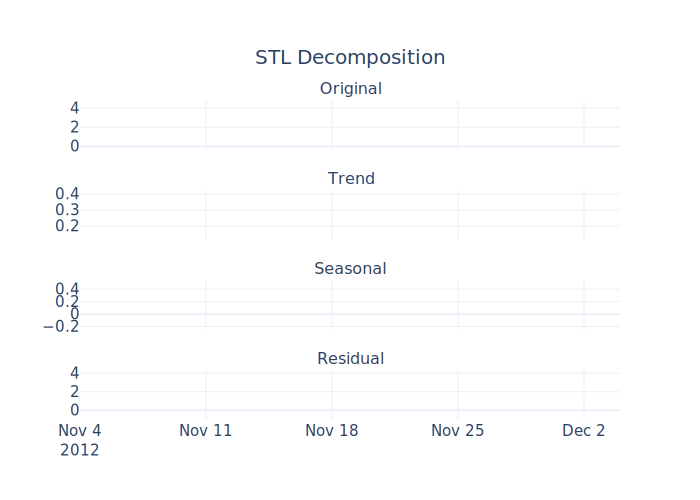

In [38]:
#Let's zoom in on a few days to better see the seasonality extracted
fig.update_xaxes(type="date", range=["2012-11-4", "2012-12-4"])
fig.write_image("imgs/chapter_03/stl_decomposition_zoomed.png")
fig.show(renderer="svg")

### Seasonality and Trend Decomposition using Loess and Fourier Terms (Fourier Decomposition)

In [46]:
#Doesn't support missing values, and expects a series or datafeame with datetime index
stl = FourierDecomposition(seasonality_period="hour", model = "additive", n_fourier_terms=5)
res_new = stl.fit(pd.Series(ts.squeeze(), index=ts_df.index))

In [56]:
# fig = res_new.plot(interactive=True)
# fig.update_layout(
#             legend=dict(
#                 font=dict(size=15),
#                 orientation="h",
#                 yanchor="bottom",
#                 y=0.98,
#                 xanchor="right",
#                 x=1,
#             ),
#             yaxis=dict(
#                 # title_text=ylabel,
#                 titlefont=dict(size=15),
#                 tickfont=dict(size=15),
#             ),
#             xaxis=dict(
#                 # title_text=xlabel,
#                 titlefont=dict(size=15),
#                 tickfont=dict(size=15),
#             )
#         )
# fig.write_image("imgs/chapter_03/fourier_decomposition_hourly.png")
# fig.show(renderer="svg")

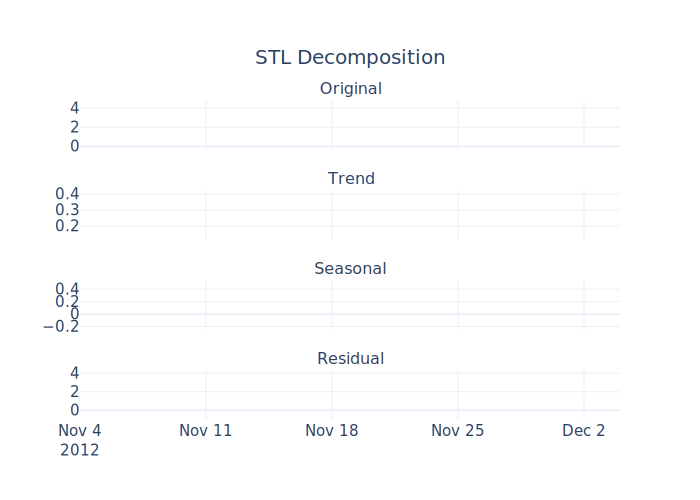

In [48]:
fig.update_xaxes(type="date", range=["2012-11-4", "2012-12-4"])
fig.write_image("imgs/chapter_03/fourier_decomposition_hourly_zoomed.png")
fig.show(renderer="svg")

#### Custom Seasonality

In [49]:
#Making a custom seasonality term
ts_df["dayofweek"] = ts_df.index.dayofweek
ts_df["hour"] = ts_df.index.hour

#Creating a sorted unique combination df
map_df = ts_df[["dayofweek","hour"]].drop_duplicates().sort_values(["dayofweek", "hour"])

# Assigning an ordinal variable to capture the order
map_df["map"] = np.arange(1, len(map_df)+1)

# mapping the oprdinal mapping back to the original df and getting the seasonality array
seasonality = ts_df.merge(map_df, on=["dayofweek","hour"], how='left', validate="many_to_one")['map']

In [50]:
stl = FourierDecomposition(model = "additive", n_fourier_terms=50)
res_new = stl.fit(pd.Series(ts, index=ts_df.index), seasonality=seasonality)

In [52]:
# fig = res_new.plot(interactive=True)
# fig.update_layout(
#             legend=dict(
#                 font=dict(size=15),
#                 orientation="h",
#                 yanchor="bottom",
#                 y=0.98,
#                 xanchor="right",
#                 x=1,
#             ),
#             yaxis=dict(
#                 # title_text=ylabel,
#                 titlefont=dict(size=15),
#                 tickfont=dict(size=15),
#             ),
#             xaxis=dict(
#                 # title_text=xlabel,
#                 titlefont=dict(size=15),
#                 tickfont=dict(size=15),
#             )
#         )
# fig.write_image("imgs/chapter_03/fourier_decomposition.png")
# fig.show(renderer="svg")

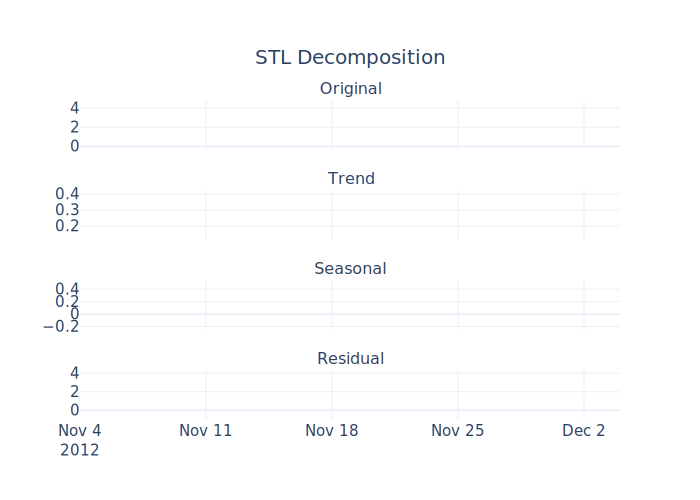

In [53]:
fig.update_xaxes(type="date", range=["2012-11-4", "2012-12-4"])
fig.write_image("imgs/chapter_03/fourier_decomposition_zoomed.png")
fig.show(renderer="svg")

### Multiple Seasonality Decomposition using Loess (MSTL)

#### Using Averages as the seasonal model

In [54]:
stl = MultiSeasonalDecomposition(seasonal_model="averages",seasonality_periods=[48*365, 48*7, 48], model = "additive")
res_new = stl.fit(pd.Series(ts, index=ts_df.index))

In [57]:
# fig = res_new.plot(interactive=True)

# fig.update_layout(
#             legend=dict(
#                 font=dict(size=15),
#                 orientation="h",
#                 yanchor="bottom",
#                 y=0.98,
#                 xanchor="right",
#                 x=1,
#             ),
#             yaxis=dict(
#                 # title_text=ylabel,
#                 titlefont=dict(size=15),
#                 tickfont=dict(size=15),
#             ),
#             xaxis=dict(
#                 # title_text=xlabel,
#                 titlefont=dict(size=15),
#                 tickfont=dict(size=15),
#             )
#         )
# fig.write_image("imgs/chapter_03/mstl_decomposition_averages.png")
# fig.show(renderer="svg")

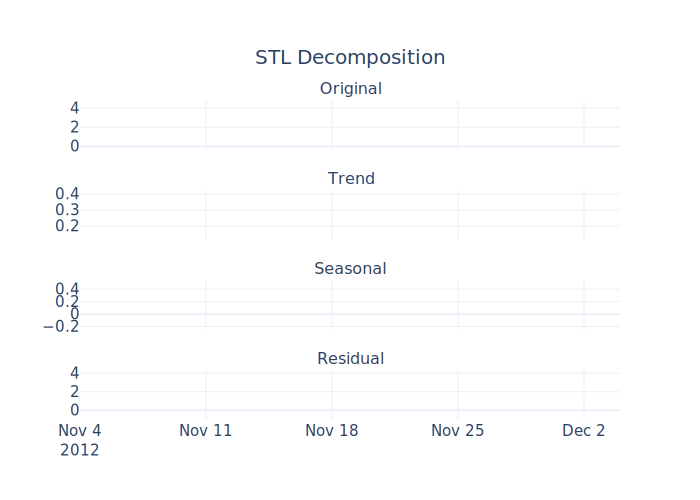

In [58]:
fig.update_xaxes(type="date", range=["2012-11-4", "2012-12-4"])

fig.write_image("imgs/chapter_03/mstl_decomposition_averages_zoomed.png")
fig.show(renderer="svg")

#### Using Fourier Decomposition as Seasonal Model

In [59]:
stl = MultiSeasonalDecomposition(seasonal_model="fourier",seasonality_periods=["day_of_year", "day_of_week", "hour"],
                                 model = "additive",
                                 n_fourier_terms=10)

res_new = stl.fit(pd.Series(ts, index=ts_df.index))

In [61]:
# fig = res_new.plot(interactive=True)
# fig.update_layout(
#             legend=dict(
#                 font=dict(size=15),
#                 orientation="h",
#                 yanchor="bottom",
#                 y=0.98,
#                 xanchor="right",
#                 x=1,
#             ),
#             yaxis=dict(
#                 # title_text=ylabel,
#                 titlefont=dict(size=15),
#                 tickfont=dict(size=15),
#             ),
#             xaxis=dict(
#                 # title_text=xlabel,
#                 titlefont=dict(size=15),
#                 tickfont=dict(size=15),
#             )
#         )
# fig.write_image("imgs/chapter_03/mstl_decomposition_fourier.png")
# fig.show(renderer="svg")

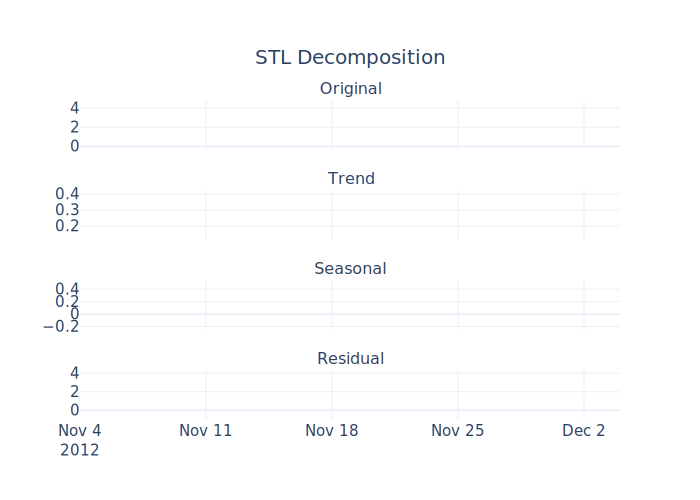

In [62]:
fig.update_xaxes(type="date", range=["2012-11-4", "2012-12-4"])
fig.write_image("imgs/chapter_03/mstl_decomposition_fourier_zoomed.png")
fig.show(renderer="svg")

### MSTL decomposition in STATSMODELS

In [63]:
exp_block_df.head()

timestamp      LCLid  energy_consumption frequency  series_length  \
0 2012-01-01 00:00:00  MAC000050               0.175     30min          37872   
1 2012-01-01 00:30:00  MAC000050               0.212     30min          37872   
2 2012-01-01 01:00:00  MAC000050               0.313     30min          37872   
3 2012-01-01 01:30:00  MAC000050               0.302     30min          37872   
4 2012-01-01 02:00:00  MAC000050               0.257     30min          37872   

  stdorToU    Acorn Acorn_grouped     file    holidays  ...  windBearing  \
0      Std  ACORN-D      Affluent  block_7  NO_HOLIDAY  ...          229   
1      Std  ACORN-D      Affluent  block_7  NO_HOLIDAY  ...          229   
2      Std  ACORN-D      Affluent  block_7  NO_HOLIDAY  ...          238   
3      Std  ACORN-D      Affluent  block_7  NO_HOLIDAY  ...          238   
4      Std  ACORN-D      Affluent  block_7  NO_HOLIDAY  ...          229   

   temperature  dewPoint  pressure  apparentTemperature  windSpeed  \
0        12.12     10.97   1008.10                12.12       5.90   
1        12.12     10.97   1008.10                12.12       5.90   
2        12.59     11.02   1007.88                12.59       6.06   
3        12.59     11.02   1007.88                12.59       6.06   
4        12.45     11.04   1007.95                12.45       5.31   

   precipType                 icon humidity        summary  
0        rain  partly-cloudy-night     0.93  Mostly Cloudy  
1        rain  partly-cloudy-night     0.93  Mostly Cloudy  
2        rain               cloudy     0.90       Overcast  
3        rain               cloudy     0.90       Overcast  
4        rain  partly-cloudy-night     0.91  Mostly Cloudy  

[5 rows x 21 columns]

In [64]:
ts_df_mstl = exp_block_df[exp_block_df.LCLid=="MAC000050"][['timestamp','energy_consumption']].set_index('timestamp')
ts_df_mstl.head()

energy_consumption
timestamp                              
2012-01-01 00:00:00               0.175
2012-01-01 00:30:00               0.212
2012-01-01 01:00:00               0.313
2012-01-01 01:30:00               0.302
2012-01-01 02:00:00               0.257

In [65]:
stl_kwargs = {"seasonal_deg": 0, }
mstl = MSTL(ts_df_mstl['energy_consumption'], 
            periods=[48, 48*7], 
            #windows=[101, 101],  # Setting this large along with `seasonal_deg=0` will force the seasonality to be periodic.
            #stl_kwargs = stl_kwargs,
            )
res = mstl.fit()

In [66]:
res.trend.head()

timestamp
2012-01-01 00:00:00    0.728921
2012-01-01 00:30:00    0.728886
2012-01-01 01:00:00    0.728851
2012-01-01 01:30:00    0.728815
2012-01-01 02:00:00    0.728779
Name: trend, dtype: float64

In [67]:
res.seasonal.head()

seasonal_48  seasonal_336
timestamp                                     
2012-01-01 00:00:00    -0.670997      0.306593
2012-01-01 00:30:00    -0.514085      0.016823
2012-01-01 01:00:00    -0.544906      0.099274
2012-01-01 01:30:00    -0.535217      0.038988
2012-01-01 02:00:00    -0.552320      0.035324

In [68]:
res.resid.head()

timestamp
2012-01-01 00:00:00   -0.189517
2012-01-01 00:30:00   -0.019623
2012-01-01 01:00:00    0.029782
2012-01-01 01:30:00    0.069415
2012-01-01 02:00:00    0.045216
Name: resid, dtype: float64

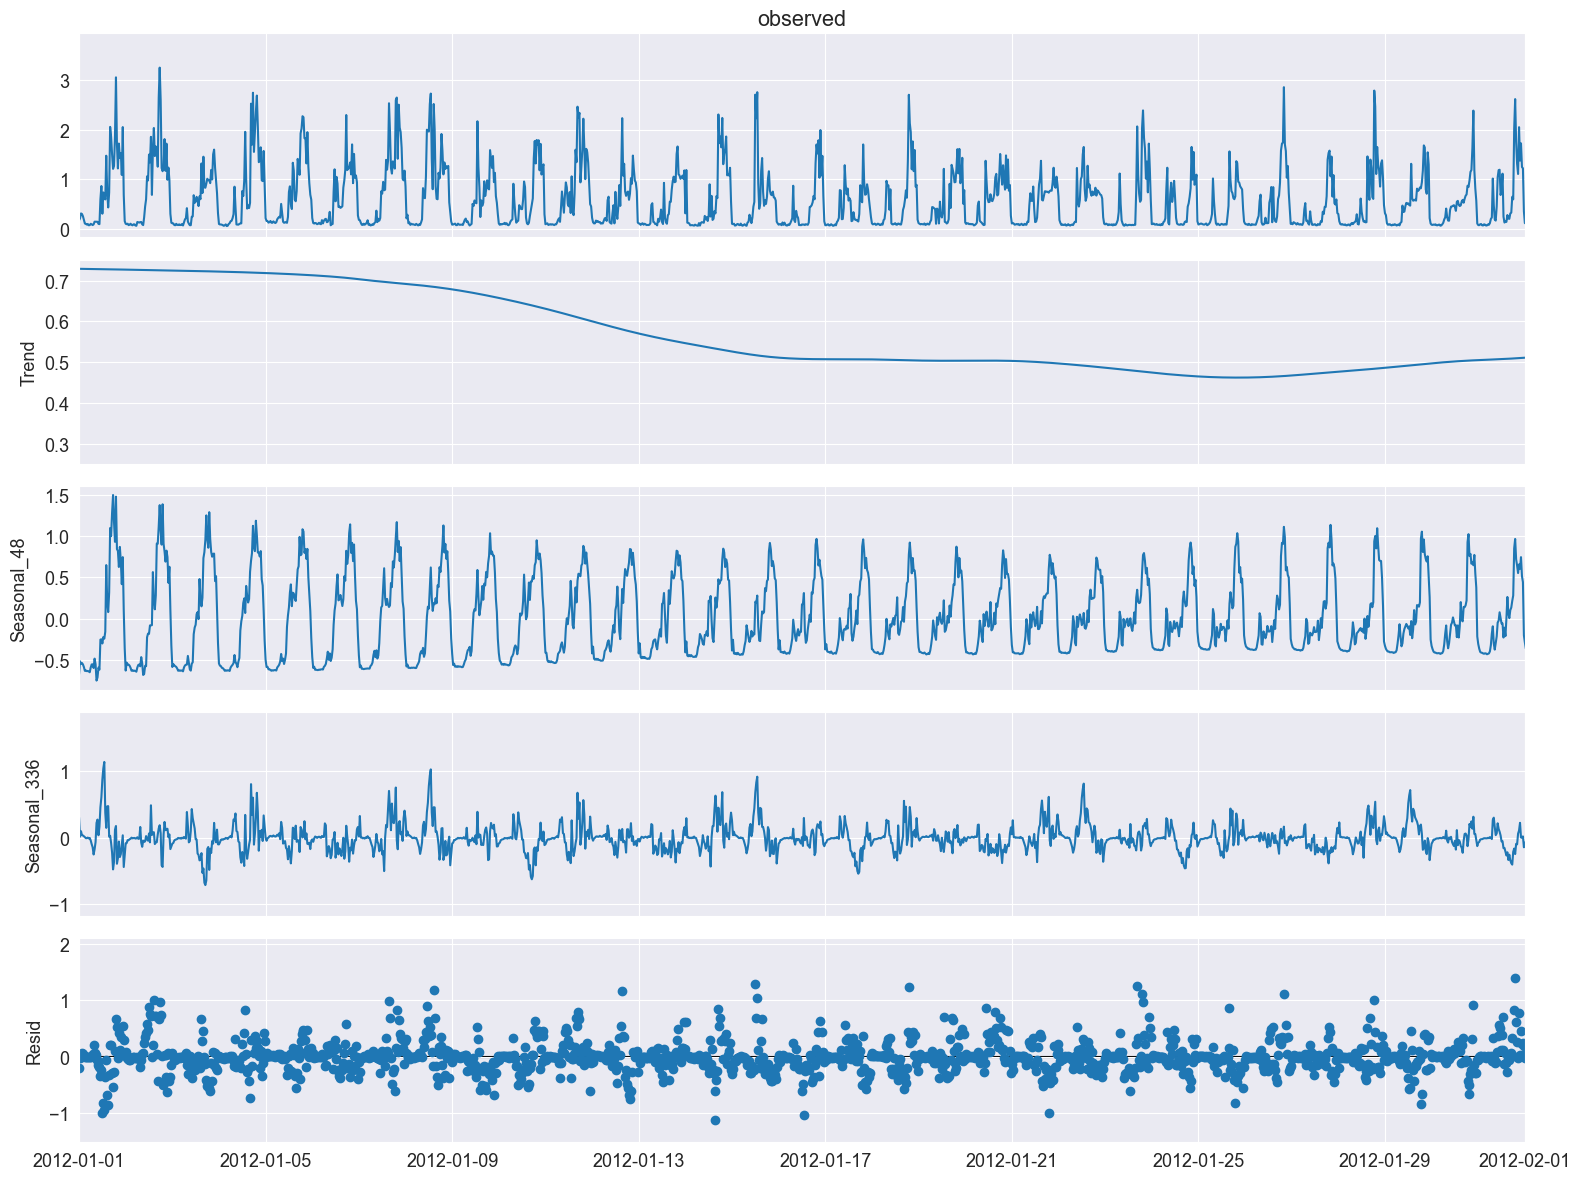

In [71]:
sns.set_style("darkgrid")
plt.rc("figure", figsize=(16, 12))
plt.rc("font", size=13)

# Creating a plot
fig = res.plot()

for ax in fig.axes:
    ax.set_xlim(pd.Timestamp('2012-01-01'), pd.Timestamp('2012-02-01'))

plt.tight_layout()  # Adjust layout to make sure everything fits without overlapping
plt.show()